<a href="https://colab.research.google.com/github/JojayD/Instacart_Association_Rule_Mining/blob/main/Instacart_Association_Rule_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instacart Market Basket Analysis
Association Rule Mining Project

This notebook will load the Instacart dataset, preprocess it for association rule mining, and provide descriptive statistics and visualizations.

In [2]:
# Download latest version

In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [4]:
# Load data (Ensure the .csv files are in your environment)
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

## Merge and Prepare Transaction Data

In [5]:
#Dropping an unescessary item

orders.drop(columns=['user_id'], inplace=True)
print(orders.columns)

Index(['order_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')


In [6]:
# Merge product info
merged = order_products_prior.merge(products, on='product_id')
merged = merged.merge(aisles, on='aisle_id')
merged = merged.merge(departments, on='department_id')
print(merged.columns)
# Group into transactions
basket = merged.groupby(['order_id'])['product_name'].apply(list)
basket.head()

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'aisle', 'department'],
      dtype='object')


,product_name
order_id,
2,"[Organic Egg Whites, Michigan Organic Kale, Ga..."
3,[Total 2% with Strawberry Lowfat Greek Straine...
4,"[Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr..."
5,"[Bag of Organic Bananas, Just Crisp, Parmesan,..."
6,"[Cleanse, Dryer Sheets Geranium Scent, Clean D..."


## Encode Transactions

In [7]:
# Sample a subset of baskets
basket_small = basket.sample(n=10000, random_state=42)

# Encode a smaller basket
te = TransactionEncoder()
basket_encoded = te.fit(basket_small).transform(basket_small)
basket_df = pd.DataFrame(basket_encoded, columns=te.columns_)

item_frequencies = basket_df.sum()
print(basket_df.head())

   #2 Coffee Filters  0 Calorie Acai Raspberry Water Beverage  \
0              False                                    False   
1              False                                    False   
2              False                                    False   
3              False                                    False   
4              False                                    False   

   0 Calorie Fuji Apple Pear Water Beverage  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   0 Calorie Strawberry Dragonfruit Water Beverage  0% Fat Free Organic Milk  \
0                                            False                     False   
1                                            False                     False   
2                                            False                     False   
3     

In [8]:
item_frequencies = basket_df.sum()

# Display the results
print(item_frequencies)

#2 Coffee Filters                                             3
0 Calorie Acai Raspberry Water Beverage                       1
0 Calorie Fuji Apple Pear Water Beverage                      2
0 Calorie Strawberry Dragonfruit Water Beverage               1
0% Fat Free Organic Milk                                     10
                                                             ..
with Xylitol Cinnamon 18 Sticks Sugar Free Gum                1
with Xylitol Island Berry Lime 18 Sticks Sugar Free Gum       1
with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum     1
with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum        1
with a Splash of Pineapple Coconut Water                      1
Length: 16561, dtype: int64


## Mine Frequent Itemsets and Generate Rules

In [10]:
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

# 1. Define candidate support thresholds
min_supports = [0.005, 0.01, 0.02, 0.03]  # fractions of total transactions :contentReference[oaicite:2]{index=2}

# 2. Evaluate each threshold
results = []
for ms in min_supports:
    # 2a. Generate frequent itemsets
    fi = apriori(basket_df, min_support=ms, use_colnames=True)
    # 2b. If no frequent itemsets, record zero rules
    if fi.empty:
        results.append({'min_support': ms, 'n_rules': 0, 'avg_lift': float('nan')})
        continue
    # 2c. Mine association rules with lift ≥ 1.0
    rules = association_rules(fi, metric="lift", min_threshold=1.0)
    results.append({
        'min_support': ms,
        'n_rules': len(rules),
        'avg_lift': rules['lift'].mean()  # average lift of rules :contentReference[oaicite:3]{index=3}
    })

# 3. Identify the best threshold (highest avg_lift among thresholds with ≥1 rule)
results_df = pd.DataFrame(results)
best = results_df[results_df['n_rules'] > 0].loc[results_df['avg_lift'].idxmax()]
best_support = best['min_support']  # optimal support value :contentReference[oaicite:4]{index=4}

# 4. Rerun mining at the best threshold and show top 10 rules by lift
best_fi = apriori(basket_df, min_support=best_support, use_colnames=True)
best_rules = association_rules(best_fi, metric="lift", min_threshold=1.0)
top_rules = best_rules[['antecedents','consequents','support','confidence','lift']]\
    .sort_values(by='lift', ascending=False).head(10)

print(f"Best min_support: {best_support}, Avg Lift: {best['avg_lift']:.3f}")
print(f"Number of rules with lift ≥ 1.0: {best['n_rules']}")

print(top_rules)  # shows the top co-purchase patterns :contentReference[oaicite:5]{index=5}


Best min_support: 0.005, Avg Lift: 2.204
Number of rules with lift ≥ 1.0: 160.0
                antecedents             consequents  support  confidence  \
102                 (Limes)      (Organic Cilantro)   0.0060    0.137300   
103      (Organic Cilantro)                 (Limes)   0.0060    0.259740   
136  (Organic Yellow Onion)        (Organic Garlic)   0.0069    0.198276   
137        (Organic Garlic)  (Organic Yellow Onion)   0.0069    0.197708   
93                  (Limes)           (Large Lemon)   0.0089    0.203661   
92            (Large Lemon)                 (Limes)   0.0089    0.189362   
138  (Organic Hass Avocado)         (Organic Lemon)   0.0074    0.106017   
139         (Organic Lemon)  (Organic Hass Avocado)   0.0074    0.265233   
95        (Organic Avocado)           (Large Lemon)   0.0087    0.166667   
94            (Large Lemon)       (Organic Avocado)   0.0087    0.185106   

         lift  
102  5.943713  
103  5.943713  
136  5.681257  
137  5.681257  
93 

## Exploring other metrics


Confidence: Measures the likelihood of the consequent being purchased given that the antecedent is purchased.

In [11]:
# Exploring other metrics
# Confidence: Measures the likelihood of the consequent being purchased given that the antecedent is purchased.
print("\nTop 10 rules by confidence:")
top_rules_confidence = best_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='confidence', ascending=False).head(10)
print(top_rules_confidence)

# Support: Measures the frequency of both antecedent and consequent appearing together in transactions.
print("\nTop 10 rules by support:")
top_rules_support = best_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='support', ascending=False).head(10)
print(top_rules_support)

# Conviction: Measures how much the consequent depends on the antecedent. A high conviction indicates strong dependence.
print("\nTop 10 rules by conviction:")
top_rules_conviction = best_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'conviction']].sort_values(by='conviction', ascending=False).head(10)
top_rules_conviction



Top 10 rules by confidence:
                               antecedents               consequents  support  \
65                    (Organic Fuji Apple)                  (Banana)   0.0105   
50                      (Honeycrisp Apple)                  (Banana)   0.0084   
47                        (Cucumber Kirby)                  (Banana)   0.0096   
26  (Organic Large Extra Fancy Fuji Apple)  (Bag of Organic Bananas)   0.0072   
82                       (Red Vine Tomato)                  (Banana)   0.0056   
58                       (Organic Avocado)                  (Banana)   0.0162   
42                           (Blueberries)                  (Banana)   0.0054   
30                   (Organic Raspberries)  (Bag of Organic Bananas)   0.0127   
80                       (Original Hummus)                  (Banana)   0.0064   
52                           (Large Lemon)                  (Banana)   0.0132   

    confidence      lift  
65    0.375000  2.513405  
50    0.370044  2.480188 

,antecedents,consequents,support,confidence,lift,conviction
65,(Organic Fuji Apple),(Banana),0.0105,0.375000,2.513405,1.361280
50,(Honeycrisp Apple),(Banana),0.0084,0.370044,2.480188,1.350571
26,(Organic Large Extra Fancy Fuji Apple),(Bag of Organic Bananas),0.0072,0.331797,2.931071,1.327142
103,(Organic Cilantro),(Limes),0.0060,0.259740,5.943713,1.291844
47,(Cucumber Kirby),(Banana),0.0096,0.332180,2.226407,1.273996
139,(Organic Lemon),(Organic Hass Avocado),0.0074,0.265233,3.799899,1.265980
30,(Organic Raspberries),(Bag of Organic Bananas),0.0127,0.288636,2.549791,1.246620
82,(Red Vine Tomato),(Banana),0.0056,0.312849,2.096844,1.238156
58,(Organic Avocado),(Banana),0.0162,0.310345,2.080059,1.233660
128,(Organic Zucchini),(Organic Baby Spinach),0.0075,0.233645,3.258645,1.211318


## Analyze Timing Features (Optional Enhancement)

In [12]:
# Timing descriptive stats
orders['order_hour_of_day'].describe()

# Bin time of day
orders['time_of_day'] = pd.cut(orders['order_hour_of_day'],
                               bins=[-1,5,11,17,23],
                               labels=['Night','Morning','Afternoon','Evening'])

# Show distribution
orders['time_of_day'].value_counts(normalize=True) * 100

,proportion
time_of_day,
Afternoon,47.320366
Morning,33.075959
Evening,17.754407
Night,1.849268


Conclusion we will be be using lift as it represents true associations beyond overall frequency

## Visualize Top Products and Departments

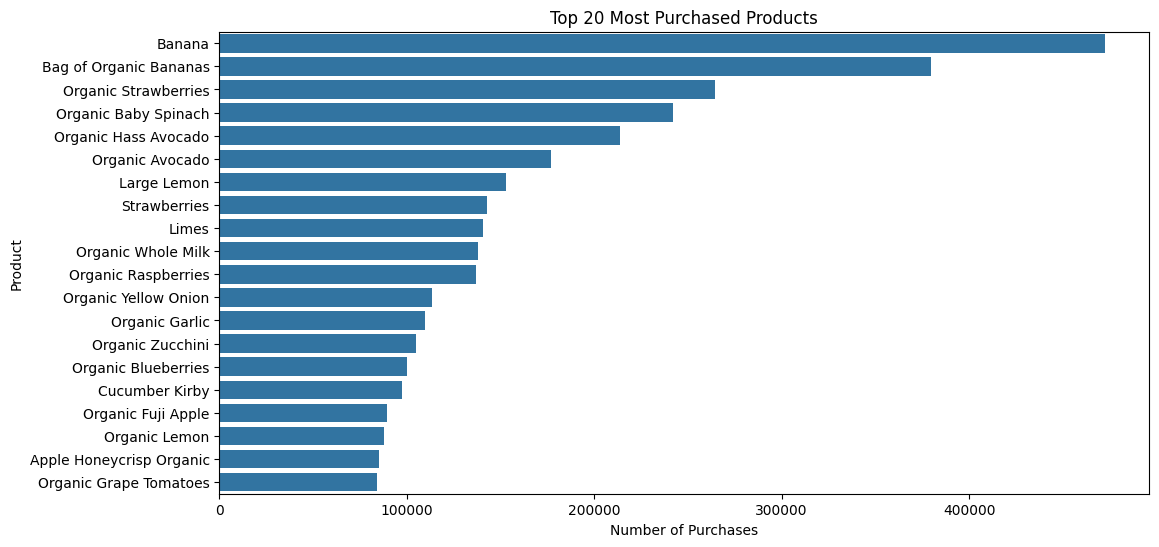

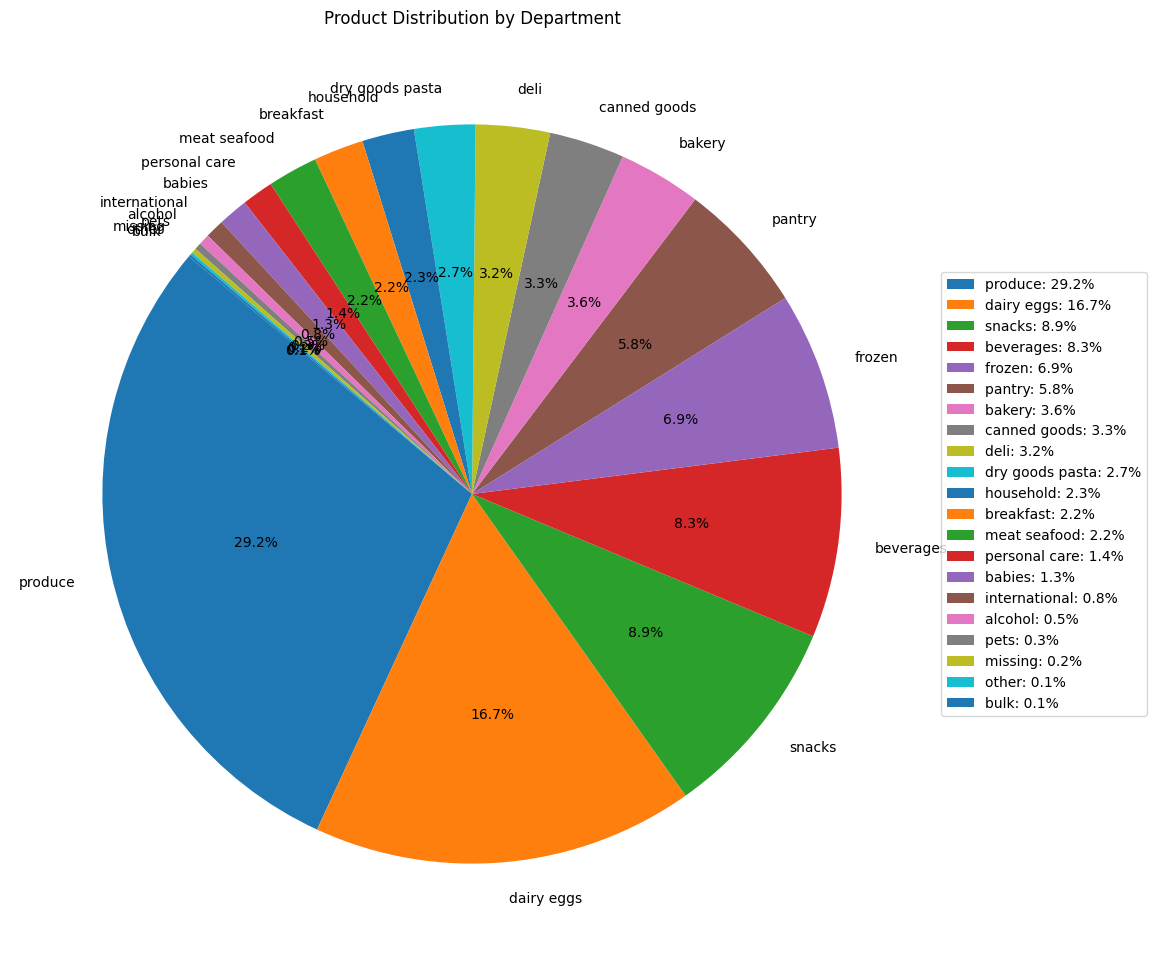

In [13]:
# Plot top 20 most purchased products
top_products = merged['product_name'].value_counts().head(20)
plt.figure(figsize=(12, 6))
sns.barplot(y=top_products.index, x=top_products.values)
plt.title('Top 20 Most Purchased Products')
plt.xlabel('Number of Purchases')
plt.ylabel('Product')
plt.show()

# Plot department distribution with percentages in legend
dept_counts = merged['department'].value_counts()
plt.figure(figsize=(12, 12))
plt.pie(dept_counts,
        labels=dept_counts.index,  # Remove labels from pie chart
        autopct='%1.1f%%',
        startangle=140)
plt.title('Product Distribution by Department')

# Create legend labels with percentages
legend_labels = [f'{dept}: {percentage:.1f}%' for dept, percentage in zip(dept_counts.index, dept_counts / dept_counts.sum() * 100)]

# Add legend with custom labels
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

## Feature engineering

---






## Filter & Validate:

Apply these thresholds, extract the final rule set, then validate on a hold-out sample or future orders to ensure stability.

In [14]:
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np

# 1. Split data
train_df = basket_df.sample(frac=0.7, random_state=42)  # 70% train
test_df  = basket_df.drop(train_df.index)               # 30% hold-out :contentReference[oaicite:10]{index=10}

# 2. Mine rules on training we are using the best min_support
freq_train = apriori(train_df, min_support=0.005, use_colnames=True)
rules_train = association_rules(freq_train, metric="lift", min_threshold=1.2)

# 3. Validate on hold-out
results = []
for _, rule in rules_train.iterrows():
    X = list(rule['antecedents']); Y = list(rule['consequents'])
    # recompute metrics on test_df...
    sup_test = np.mean(test_df[X+Y].all(axis=1))
    conf_test = sup_test / np.mean(test_df[X].all(axis=1))
    lift_test = conf_test / np.mean(test_df[Y].all(axis=1))
    results.append((tuple(X), tuple(Y), sup_test, conf_test, lift_test))

# 4. Compare train vs. test metrics and filter for stability
validated = [(X, Y, s, c, l) for (X,Y,s,c,l), r in zip(results, rules_train.itertuples())
             if abs(c - r.confidence) < 0.1 and l > 1.1]
print(f"Number of rules validated: {len(validated)}")


Number of rules validated: 149


Antecedent (items on the left of “→”)

Consequent (items on the right of “→”)

Support – fraction of all transactions containing both antecedent and consequent

Confidence – probability of the consequent given the antecedent

Lift – how much more often they occur together than if they were independent

In [15]:
for el in validated:
    print(el)

(('Banana',), ('100% Whole Wheat Bread',), np.float64(0.005333333333333333), np.float64(0.034782608695652174), np.float64(1.6830294530154277))
(('100% Whole Wheat Bread',), ('Banana',), np.float64(0.005333333333333333), np.float64(0.25806451612903225), np.float64(1.683029453015428))
(('Apple Honeycrisp Organic',), ('Bag of Organic Bananas',), np.float64(0.005), np.float64(0.1744186046511628), np.float64(1.5856236786469344))
(('Bag of Organic Bananas',), ('Apple Honeycrisp Organic',), np.float64(0.005), np.float64(0.045454545454545456), np.float64(1.5856236786469344))
(('Apple Honeycrisp Organic',), ('Banana',), np.float64(0.006666666666666667), np.float64(0.23255813953488375), np.float64(1.5166835187057637))
(('Banana',), ('Apple Honeycrisp Organic',), np.float64(0.006666666666666667), np.float64(0.04347826086956522), np.float64(1.5166835187057637))
(('Apple Honeycrisp Organic',), ('Organic Hass Avocado',), np.float64(0.006666666666666667), np.float64(0.23255813953488375), np.float64(3

What this data tells us?


*   Organic Hass Avocado → Org. Bananas: support 1.57% means it’s in ~157 of every 10,000 orders; confidence ~22.9% means nearly 1 in 4 avocado buyers also buy bananas; lift ~2.08 means this pairing is twice as likely as random chance
Data School
.


* Organic Raspberries → Org. Bananas has an even higher lift (~2.72), marking it as a very strong positive association



Now lets refine association rule mining by incorporate product_frequency